In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# Regression

Z = severity of symptoms

X = dosage of medication given

Y = recovery time

### Note: this error term has nonzero mean!  Then it is important to allow for an intercept for Y
### Even though no intercept is apparent in the equation for Y

In [3]:
np.random.seed(0)
numrows = 1000
Z_severity = np.minimum(np.maximum(np.random.normal(5, 2, (numrows,)), 0), 10)
X_dosage = Z_severity + np.random.uniform(0, 10, (numrows,))
Y_recovery = np.maximum(2 * Z_severity - 0.5 * X_dosage + np.random.uniform(0, 10, (numrows,)), 0)
df = pd.DataFrame({"X": X_dosage, "Y": Y_recovery, "Z": Z_severity})

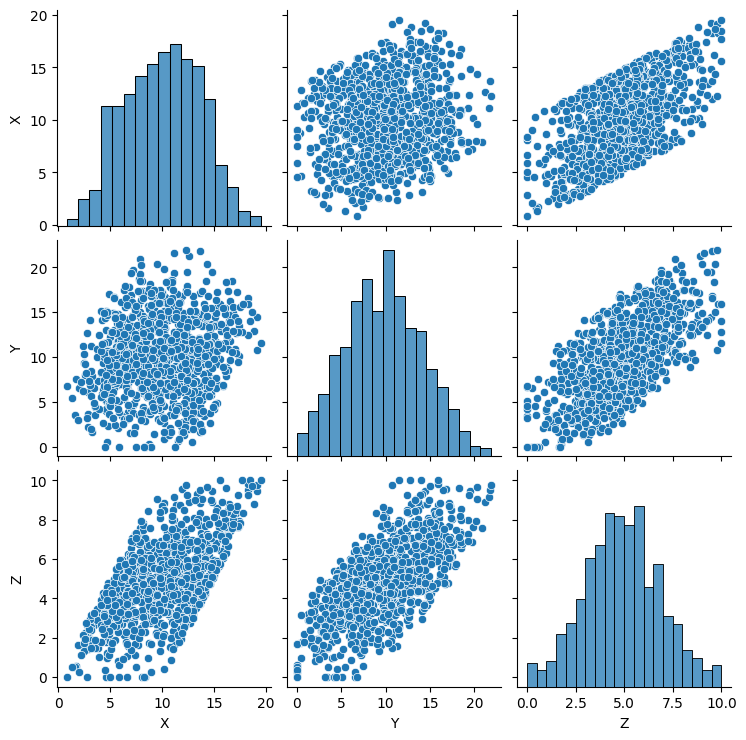

In [4]:
sns.pairplot(df)

### Doesn't quite work - confounder (Z) changes X coefficient

In [5]:
results = sm.OLS(df.Y, sm.add_constant(df[["X"]])).fit()
results.params

const    8.191544
X        0.163954
dtype: float64

### Works - controlling for the confounder (Z) makes the coefficients correct

In [6]:
results = sm.OLS(df.Y, sm.add_constant(df[["X", "Z"]])).fit()
results.params

const    4.826447
X       -0.484418
Z        2.010365
dtype: float64

### Make X and Z more closely related

In [7]:
numrows = 10000
np.random.seed(1)
Z_severity = np.minimum(np.maximum(np.random.normal(5, 2, (numrows,)), 0), 10)
X_dosage = Z_severity + np.random.uniform(0, 0.5, (numrows,))
Y_recovery = np.maximum(2 * Z_severity - 0.5 * X_dosage + np.random.uniform(0, 10, (numrows,)), 0)
df2 = pd.DataFrame({"X": X_dosage, "Y": Y_recovery, "Z": Z_severity})

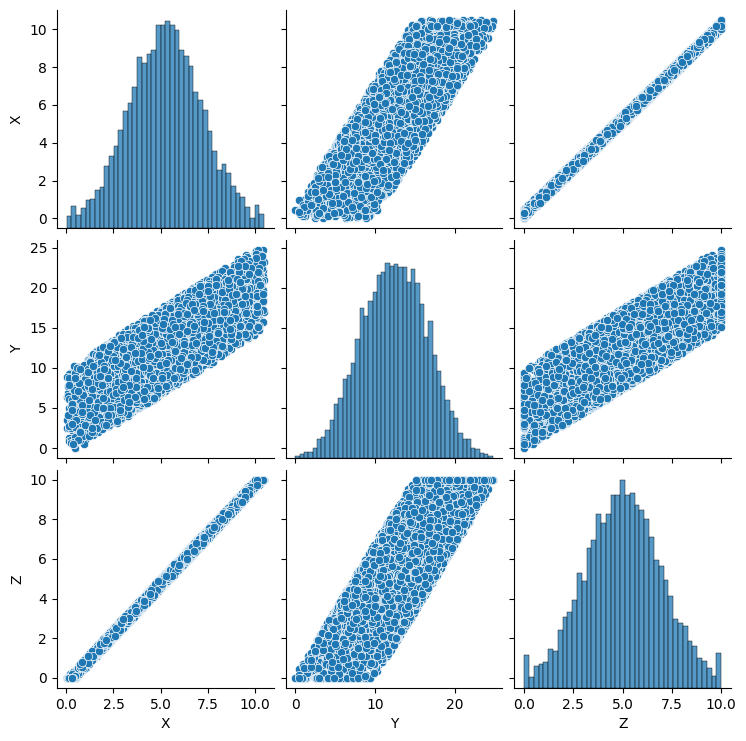

In [8]:
sns.pairplot(df2)

### Doesn't work - confounder changes X coefficient

In [9]:
results = sm.OLS(df2.Y, sm.add_constant(df2[["X"]])).fit()
results.params

const    4.541978
X        1.486010
dtype: float64

### Also doesn't work - X and Z are too highly correlated for regression to work.

In [10]:
results = sm.OLS(df2.Y, sm.add_constant(df2[["X", "Z"]])).fit()
results.params

const    5.028709
X       -0.679665
Z        2.177473
dtype: float64

In [11]:
np.corrcoef(df2.X, df2.Z)[0,1]

0.9973382861800948

### Again, be sure to include intercept here

In [12]:
variance_inflation_factor(sm.add_constant(df2[["X", "Z"]]), 1)

188.09922820443168

In [13]:
np.random.seed(0)
numrows = 10000
Z_severity = np.minimum(np.maximum(np.random.normal(5, 2, (numrows,)), 0), 10)
X_dosage = np.random.uniform(0, 10, (numrows,))
Y_recovery = np.maximum(2 * Z_severity - 0.5 * X_dosage + np.random.uniform(0, 10, (numrows,)), 0)
df3 = pd.DataFrame({"X": X_dosage, "Y": Y_recovery, "Z": Z_severity})

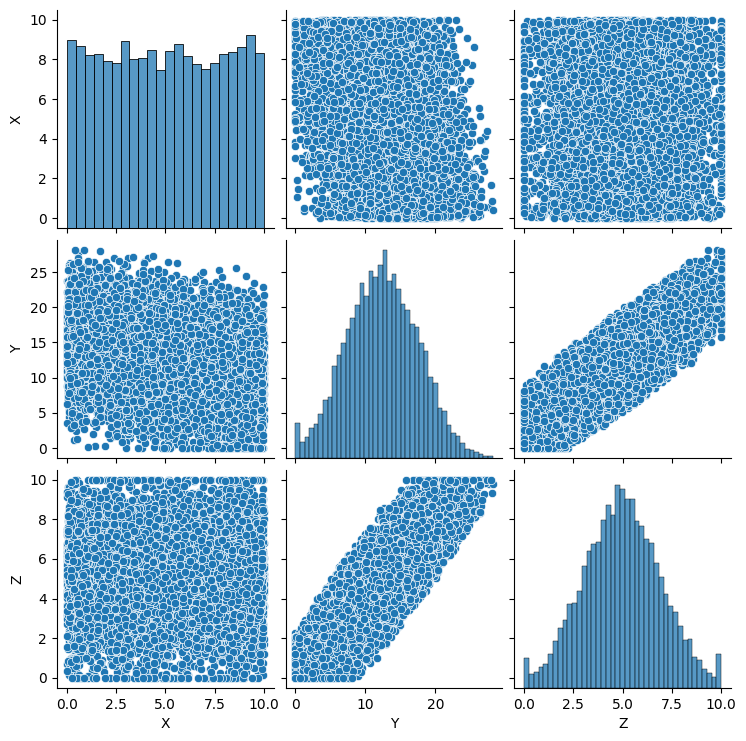

In [14]:
sns.pairplot(df3)

### This works!  X coefficient ~-0.5

In [15]:
results = sm.OLS(df3.Y, sm.add_constant(df3[["X"]])).fit()
results.params

const    14.912259
X        -0.499406
dtype: float64

In [16]:
results.bse

const    0.096022
X        0.016596
dtype: float64

In [17]:
results = sm.OLS(df3.Y, sm.add_constant(df3[["X", "Z"]])).fit()
results.params

const    5.045667
X       -0.501896
Z        1.990481
dtype: float64

In [18]:
results.bse

const    0.092557
X        0.009860
Z        0.014704
dtype: float64

# Matching

### Goal: want treatment and control items with approximately same Z values
### So that differing Z values won't alter calculation of the effect

In [20]:
numrows = 10
np.random.seed(2)
Z_severity = np.minimum(np.maximum(np.random.normal(5, 2, (numrows,)), 0), 10)
X_dosage = np.random.binomial(1, Z_severity / 10, (numrows,))
Y_recovery = np.maximum(2 * Z_severity - 2.5 * X_dosage + np.random.uniform(0, 10, (numrows,)), 0)
df_match = pd.DataFrame({"X": X_dosage, "Y": Y_recovery, "Z": Z_severity})

In [21]:
treated = df_match[df_match["X"] == 1]
control = df_match[df_match["X"] == 0]
model = NearestNeighbors(n_neighbors = 1)
result = model.fit(control[["Z"]])

In [22]:
prediction = result.kneighbors(treated[["Z"]])

In [24]:
pd.DataFrame(treated.Z).reset_index()

,index,Z
0,0,4.166484
1,1,4.887466
2,3,8.280542
3,5,3.316505
4,8,2.884096


In [25]:
pd.DataFrame(control.Z).reset_index()

,index,Z
0,2,0.727608
1,4,1.413129
2,6,6.005763
3,7,2.509424
4,9,3.181985


In [23]:
prediction[1]

array([[4],
       [2],
       [2],
       [4],
       [4]])

In [26]:
numrows = 10000
np.random.seed(0)
Z_severity = np.minimum(np.maximum(np.random.normal(5, 2, (numrows,)), 0), 10)
X_dosage = np.random.binomial(1, Z_severity / 10, (numrows,))
Y_recovery = np.maximum(2 * Z_severity - 2.5 * X_dosage + np.random.uniform(0, 10, (numrows,)), 0)
df_match = pd.DataFrame({"X": X_dosage, "Y": Y_recovery, "Z": Z_severity})
treated = df_match[df_match["X"] == 1]
control = df_match[df_match["X"] == 0]

In [27]:
treated.Y.mean() - control.Y.mean() # Different values of Z, not just different values of X

0.4891397480812856

In [28]:
model = NearestNeighbors(n_neighbors = 1)
result = model.fit(control[["Z"]])

In [29]:
prediction = result.kneighbors(treated[["Z"]])
matched_controls = control.iloc[prediction[1].flatten()]

## The effect: meant to approximate X = 1 vs X = 0 comparison "as if" Z were held constant

In [31]:
treated.Y.mean() - matched_controls.Y.mean()

-2.604208745162012

In [32]:
model = NearestNeighbors(n_neighbors = 1)
result = model.fit(treated[["Z"]]) # Memorizing Z values of treated
prediction = result.kneighbors(control[["Z"]])
matched_treated = treated.iloc[prediction[1].flatten()]
matched_treated.Y.mean() - control.Y.mean()

-2.532684685095983

In [33]:
model = NearestNeighbors(n_neighbors = 1, radius = 0.1)
result = model.fit(treated[["Z"]]) # Memorizing Z values of treated
prediction = result.radius_neighbors(control[["Z"]])
prediction[1]

array([array([1234, 2775, 3260, 1342, 1370,  718, 3318, 1078,   97,  497,  772,
              3496, 3601, 4000, 2824, 3525, 4038, 4807, 3036,  533, 1398,  712,
              4245,  361, 2746, 3209, 4799, 3405,  232, 2770,  953, 4498, 1781,
              4756, 1108, 3966, 4782,  778, 3084, 1053, 1533, 4369, 4412,  429,
              1080, 3110, 4391, 3872, 3542,  894, 4237, 2772,  810,  292, 1355,
              2019,  329,  691, 2223, 2458, 4908, 4339, 1430, 1193, 2845, 2100,
              2012, 2712, 1450, 4254, 3450, 1958, 2882, 1505, 3192, 1789, 4131,
               290, 2034])                                                     ,
       array([1406, 4633, 3885,  118, 2476, 2602, 4710, 4880, 2656, 2056, 4479,
              3350, 4327, 3076, 2318,  790, 1562, 4434, 3768, 4225, 3143, 1244,
                46, 3332, 3771, 2290, 1190,  923, 2618,  759, 2043,   98, 3265,
               560, 3754, 3310, 1275, 3792,   71, 2761, 4906, 4094, 2061, 4417,
              1103,  562, 3699, 3957, 1

In [36]:
control.iloc[0]

X    0.000000
Y    8.482639
Z    3.045444
Name: 5, dtype: float64

In [35]:
treated.iloc[[1234, 2775, 3260, 1342, 1370,  718, 3318, 1078,   97,  497,  772,
              3496, 3601, 4000, 2824, 3525, 4038, 4807, 3036,  533, 1398,  712,
              4245,  361, 2746, 3209, 4799, 3405,  232, 2770,  953, 4498, 1781,
              4756, 1108, 3966, 4782,  778, 3084, 1053, 1533, 4369, 4412,  429,
              1080, 3110, 4391, 3872, 3542,  894, 4237, 2772,  810,  292, 1355,
              2019,  329,  691, 2223, 2458, 4908, 4339, 1430, 1193, 2845, 2100,
              2012, 2712, 1450, 4254, 3450, 1958, 2882, 1505, 3192, 1789, 4131,
               290, 2034]]

,X,Y,Z
2532,1,12.009601,2.956173
5570,1,5.622265,2.957148
6572,1,13.062126,2.962468
2742,1,10.799338,2.993468
2791,1,4.602351,3.001140
...,...,...,...
6409,1,5.492634,3.119390
3631,1,9.144218,3.107559
8353,1,13.211199,3.134792
598,1,6.689086,3.139687
